# ReACT

For the following example you need the Pyhton wrapper for CAMB installed. The easiest way to do this is to use the `conda` package:

`conda install camb -c conda-forge`

In [1]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
Omega_c = 0.25
Omega_b = 0.05
h = 0.7
n_s = 0.97
A_s = 2.1e-9
m_nu = 0.06
mg1 = 1e-6

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False)
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))

p.set_matter_power(redshifts=np.linspace(0.0, 2.0, 16, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

Omega_m = p.omegam

r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Now run ReACT to get the reaction and the modified gravity linear power spectrum that will get used by HMCode.

In [3]:
react = pyreact.ReACT()

R, pofk_lin_MG = react.compute_reaction(
                                h, n_s, Omega_m, Omega_b, sigma_8, mg1,
                                z_lin, k_lin, pofk_lin_camb[0], is_transfer=False,
                                verbose=True)

Now make some plots!

Text(0.5, 1.0, 'z = 0, f_R0 = 1e-06')

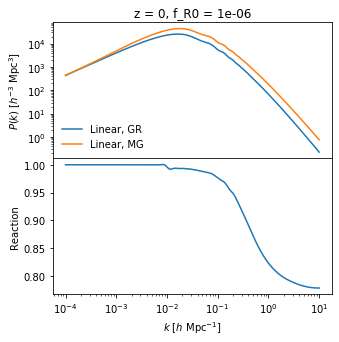

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].loglog(k_lin, pofk_lin_camb[0], label="Linear, GR")
ax[0].loglog(k_lin, pofk_lin_MG[0], label="Linear, MG")

ax[1].semilogx(k_lin, R[0])

ax[0].legend(frameon=False)

ax[0].set_ylabel("$P(k)$ [$h^{-3}$ Mpc$^3$]")
ax[1].set_ylabel("Reaction")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title(f"z = 0, f_R0 = {mg1}")
